# Eindhoven University of Technology, Netherlands.
## Mathematics & Computer Science
## Data Science Master track
## Recommender Systems
Lecturer: Dr. Vlado Menkovski
- Franziska Boenisch
- Adriano Cardace 
- Camilo Montenegro Hernandez

### Siamese networks & one-shot learning
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [ ]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, merge, concatenate, Activation
from keras.models import Model, Sequential
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
import numpy as np
import os
import pickle
from itertools import permutations
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


In [ ]:
# load data
from keras.datasets import cifar100

# we are only interested in the train data
(X, Y), (X_test, Y_test) = cifar100.load_data(label_mode="fine") 

In [ ]:
def normalize(X_train,X_test):
  #this function normalize inputs for zero mean and unit variance
  # it is used when training a model.
  # Input: training set and test set
  # Output: normalized training set and test set according to the trianing set 
  #statistics.
  mean = np.mean(X_train,axis=(0,1,2,3))
  std = np.std(X_train, axis=(0, 1, 2, 3))
  print('Set mean:',mean)
  print('Set std:',std)
  X_train = (X_train-mean)/(std+1e-7)
  X_test = (X_test-mean)/(std+1e-7)
  return X_train, X_test

In [ ]:
X, X_test = normalize(X,X_test)
print('Put the data in the following form: class, example, w, h, c')
#put the data in the following form: class, example, w, h, c
indexes = np.argsort(Y.flatten())
sorted_data = []
for i in indexes:
  sorted_data.append(X[i])
X = np.array(sorted_data)
Y = np.array(sorted(Y.flatten()))
x_list=[]
for i in range(100):
  image_class = []
  for j in range(500):
    image_class.append(X[i*500+j])
  x_list.append(np.array(image_class))
X_array = np.array(x_list)
print('Training set shape:',X_array.shape)

Set mean: 121.936059453125
Set std: 68.38895658894971
Put the data in the following form: class, example, w, h, c
Training set shape: (100, 500, 32, 32, 3)


In [ ]:
#split in training set and test
print('Split in training set and test in first 80 and later 20 categories, '+
      'respectively')
X_val = X_array[-20:, :, :, :, :]
X_train = X_array[:80, :, :, :, :]
print('Training set shape:',X_train.shape)
print('Test set shape:',X_val.shape)

Split in training set and test in first 80 and later 20 categories, respectively
Training set shape: (80, 500, 32, 32, 3)
Test set shape: (20, 500, 32, 32, 3)


In [ ]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, 3)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd 
    #half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd 
            #image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, 3)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=625, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), 
                        steps_per_epoch=steps_per_epoch, epochs=epochs)

In [ ]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()

convnet.add(Conv2D(64, (5,5), input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))
# convnet.add(Dropout(0.5))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(128, (3,3), input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))
# convnet.add(Dropout(0.5))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(256, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))

convnet.add(Conv2D(256, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))
# convnet.add(Dropout(0.5))

convnet.add(Flatten())

convnet.add(Dense(128, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect 
#to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


optimizer = optimizers.Adam(lr=0.00001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)


siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_22 (Batc (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
__________

In [ ]:
# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(siamese_net, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for 
    testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    
    categories = np.random.choice(range(n_classes), size=(N,), replace=False) 
    
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :, :]]*N).reshape(N, w, h, 3)
    support_set = X[categories, indices, :, :, :]
    support_set[0, :, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over
    k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot " 
              "learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning"
              .format(percent_correct, N))
    return percent_correct

In [ ]:
loops = 100
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, X_train)
    test_acc = test_oneshot(siamese_net, X_val)
    if test_acc >= best_acc:
        print("********* New best one-shot accuracy, saving model ********")
        siamese_net.save(os.path.join(".", "siamese.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
625/625 [==============================] - 20s 31ms/step - loss: 1.0237
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 2 ===
Epoch 1/1
625/625 [==============================] - 16s 26ms/step - loss: 0.9926
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 3 ===
Epoch 1/1
625/625 [==============================] - 16s 26ms/step - loss: 0.9701
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 4 ===
Epoch 1/1
625/625 [==============================] - 16s 25ms/step - loss: 0.9553
Evaluating mode

In [ ]:
print('Best accuracy obtained after',loops,'loops of 1 epoch each:')
print(best_acc)

Best accuracy obtained after 100 loops of 1 epoch each:
26.4


As we have 20 remaining classes, the probability for random guessing would be 1/20 which is 5%. Since we achieve a better result (26.4%), we can say that the network has actually learned a meaningful embedding.

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

#### Performance difference
The performance in the Omniglot are much higher (about 80%) compared to the one that we have for Cifar-100.

#### 3 Fundamental differences between Cifar-100 and Omniglot
1) Omniglot: 1623 different handwritten characters from 50 different alphabets, Cifar-100: 50000 images from 100 classes. Hence, we have more data available, but also more classes.

2) Omniglot is black and white (1 channel) and Cifar-100 is colored (3 channels).

3) The imagees in Omniglot are larger (105x105) and in Cifar-100 is (32x32).


#### How do the differences affect the one-shot accuracy
The differences lead to poorer results for the Cifar-100 dataset than in Omniglot. The worse results are explicable by the fact that the Cifar-100 dataset is more complex (3 channels instead of 1 and they are complex shapes not only characters). Furthermore, the number of classes is larger in Cifar-100.

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [ ]:
(X, Y), (X_test, Y_test) = cifar100.load_data(label_mode="fine")

In [ ]:
X = X.astype('float32')
X_test = X_test.astype('float32')
X, X_test = normalize(X, X_test)

Set mean: 121.93584
Set std: 68.38902


In [ ]:
#select first 80 classes
Y = Y.flatten()
indexes = Y<80
Y_test = Y_test.flatten()
indexes1 = Y_test<80

In [ ]:
X_train = X[indexes]
Y_train = Y[indexes]
print('X-Training set shape:',X_train.shape)
print('Y-Training set shape:',Y_train.shape)
print('Min class:',Y_train.min(),'Max class:', Y_train.max())
X_test = X_test[indexes1]
Y_test = Y_test[indexes1]
print('X-Test set shape:',X_test.shape)
print('Y-Test set shape:',Y_test.shape)
print('Min class:',Y_test.min(),'Max class:', Y_test.max())

X-Training set shape: (40000, 32, 32, 3)
Y-Training set shape: (40000,)
Min class: 0 Max class: 79
X-Test set shape: (8000, 32, 32, 3)
Y-Test set shape: (8000,)
Min class: 0 Max class: 79


In [ ]:
input_shape = (32, 32, 3)

weight_decay = 0.0005

convnet = Sequential()

convnet.add(Conv2D(64, (7,7), activation='relu', input_shape=input_shape, 
                   kernel_regularizer=l2(2e-4)))
#convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.3))

convnet.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape, 
                   kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(MaxPooling2D())
#convnet.add(Dropout(0.25))

convnet.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape, 
                   kernel_regularizer=l2(2e-4)))
#convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.4))

convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
#convnet.add(MaxPooling2D())
#convnet.add(Dropout(0.25))

convnet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4), 
                   padding='same'))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.4))

convnet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.4))

convnet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4), 
                   padding='same'))
convnet.add(BatchNormalization())
convnet.add(MaxPooling2D())

convnet.add(Conv2D(512, (3,3), activation='relu', kernel_regularizer=l2(2e-4), 
                   padding='same'))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.4))

convnet.add(Conv2D(512, (3,3), activation='relu', kernel_regularizer=l2(2e-4), 
                   padding='same'))
convnet.add(BatchNormalization())


convnet.add(Conv2D(512, (3,3), activation='relu', kernel_regularizer=l2(2e-4), 
                   padding='same'))
convnet.add(Flatten())

convnet.add(Dense(2048, activation="relu", kernel_regularizer=l2(1e-3)))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Dense(128, activation="relu", kernel_regularizer=l2(1e-3)))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
#convnet.add(BatchNormalization())
#convnet.add(Dropout(0.4))

convnet.add(Dense(80, activation="softmax", kernel_regularizer=l2(1e-3),
                  name='80Classes'))

convnet.summary()



optimizer = optimizers.Adam(lr=0.0001)
# optimizer= optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
convnet.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 26, 26, 64)        9472      
_________________________________________________________________
batch_normalization_35 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 22, 22, 64)        102464    
_________________________________________________________________
batch_normalization_36 (Batc (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 9, 9, 128)         73856     
__________

In [ ]:
# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(convnet, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
y_categorical = to_categorical(Y_train, 80)
y_categorical_test = to_categorical(Y_test, 80)
print('One hot vectors for the labels:',y_categorical.shape)

One hot vectors for the labels: (40000, 80)


In [ ]:
#data augmentation
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            # divide inputs by std of the dataset
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            # randomly rotate images in the range (degrees, 0 to 180)
            rotation_range=15,  
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,  
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,  
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [ ]:
batch_size = 100
epochs = 50

convnet.fit_generator(datagen.flow(X_train, y_categorical,
                      batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=X_train.shape[0] // batch_size,
                      validation_data=(X_test,y_categorical_test))

score = convnet.evaluate(X_test,y_categorical_test)


Epoch 1/50
400/400 [==============================] - 33s 83ms/step - loss: 7.3650 - acc: 0.0350 - val_loss: 7.4935 - val_acc: 0.0395
Epoch 2/50
400/400 [==============================] - 25s 62ms/step - loss: 6.7531 - acc: 0.0689 - val_loss: 6.9806 - val_acc: 0.0550
Epoch 3/50
400/400 [==============================] - 25s 62ms/step - loss: 6.3879 - acc: 0.0973 - val_loss: 6.3876 - val_acc: 0.0746
Epoch 4/50
400/400 [==============================] - 27s 67ms/step - loss: 6.0494 - acc: 0.1170 - val_loss: 6.0996 - val_acc: 0.0875
Epoch 5/50
400/400 [==============================] - 25s 63ms/step - loss: 5.7354 - acc: 0.1312 - val_loss: 5.8167 - val_acc: 0.1071
Epoch 6/50
400/400 [==============================] - 25s 63ms/step - loss: 5.4337 - acc: 0.1507 - val_loss: 5.4625 - val_acc: 0.1275
Epoch 7/50
400/400 [==============================] - 26s 65ms/step - loss: 5.1540 - acc: 0.1661 - val_loss: 5.1178 - val_acc: 0.1576
Epoch 8/50
400/400 [==============================] - 25s 62ms

In [ ]:
print('Metrics obtained using the test set, first 80 classes of cifar 100 test set')
print('Loss value obtained after {} epochs: {}'.format(epochs,score[0]))
print('Accuracy value obtained after {} epochs: {}%'
      .format(epochs,score[1]*100))

Metrics obtained using the test set, first 80 classes of cifar 100 test set
Loss value obtained after 50 epochs: 2.491881098270416
Accuracy value obtained after 50 epochs: 48.6875%


In [ ]:
#take only the last 20 classes from the training set to evaluate neural codes 
#from CNN
(X, Y), (X_test, Y_test) = cifar100.load_data(label_mode="fine")
X = X.astype('float32')
X_test = X_test.astype('float32')
X, X_test = normalize(X, X_test)

#put the data in the following form: class, example, w, h, c
indexes = np.argsort(Y.flatten())
sorted_data = []
for i in indexes:
  sorted_data.append(X[i])
X = np.array(sorted_data)
Y = np.array(sorted(Y.flatten()))
x_list=[]
for i in range(100):
  image_class = []
  for j in range(500):
    image_class.append(X[i*500+j])
  x_list.append(np.array(image_class))
X_array = np.array(x_list)
#print(X_array.shape)

#class, example, w, h, c

X_train = X_array[-20:, :, :, :, :]
print('Last 20 classes training set to evaluate neural codes: '+
      str(X_train.shape))

Set mean: 121.93584
Set std: 68.38902
Last 20 classes training set to evaluate neural codes: (20, 500, 32, 32, 3)


In [ ]:
def l2Distance(a,b):
    return np.linalg.norm(a-b)

def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, 
    for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)    
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :, :]]*N).reshape(N, w, h, 3)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X,  N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net 
    over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ..."
              .format(k, N))
    for i in range(k):
        pairs, label = make_oneshot_task(N, X)
        #for each input pair, compute l2 distance between corresponding codes, 
        #if the index of the closest pair is equal to the target success
        distances = []
        for pair in pairs:
          query_image=model.predict(np.expand_dims(pair[0], axis=0))
#           print(query_image)
          test_image=model.predict(np.expand_dims(pair[1], axis=0))
#           print(test_image)
          distances.append(l2Distance(query_image,test_image))
          
        if np.argmin(distances) == np.argmax(label):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning"
              .format(percent_correct, N))
    return percent_correct

In [ ]:
fc2_model = Model(inputs=convnet.input, outputs=convnet.get_layer("80Classes")
                  .output)

test_oneshot(fc2_model, X_train)

Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning


6.4

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

The architecture is inspired by classical VGG network: blocks of convolutional layers, followed by a batch normalization layer to speed up the training, and a dropout layer to reduce overfitting. At the top of this convolutional layers, we stacked two dense layers: the former is needed to extract the codes, while the latter corresponds to a softmax layer used for the classification task.
In order to improve the accuracy of the classification, and consequently the embedding, we also added data augmentation. Thanks to this trick, we are able to achieve about 50% of accuracy for the classification task.
However, we can see that one-shot accuracy obtained with codes (6.4%), is still less than the one that we have using the Siamense network. This was probably predictable since the Siamense network is built specifically for learning embeddings.

***
## Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

```python
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        
    
    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
    margin = # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss
```


In [ ]:
(x_train, y_train), (_, _) = cifar100.load_data()

input_size = (32, 32, 3)
# embedding_dimensions = 128
batch_size = 256

169009152/169001437 [==============================] - 13s 0us/step


In [ ]:
#put the data in the following form: class, example, w, h, c
print('Put the data in the following form: class, example, w, h, c')
indexes = np.argsort(y_train.flatten())
sorted_data = []
for i in indexes:
  sorted_data.append(x_train[i])
x_train = np.array(sorted_data)
y_train = np.array(sorted(y_train.flatten()))
X=[]
for i in range(100):
  image_class = []
  for j in range(500):
    image_class.append(x_train[i*500+j])
  X.append(np.array(image_class))
X = np.array(X)
print('Training set shape:',X.shape)

Put the data in the following form: class, example, w, h, c
Training set shape: (100, 500, 32, 32, 3)


In [ ]:
#split in training set and test
print('Split in training set and test in first 80 and later 20 categories, '+
      'respectively')
X_test = X[-20:, :, :, :, :]
X = X[:80, :, :, :, :]
print('Training set shape:',X.shape)
print('Test set shape:',X_test.shape)

Split in training set and test in first 80 and later 20 categories, respectively
Training set shape: (80, 500, 32, 32, 3)
Test set shape: (20, 500, 32, 32, 3)


In [ ]:
def get_batch(batch_size, X):
    """Create batch of n triplets anchor, positive, negative"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 3 empty arrays for the input image batch
    triplet = [np.zeros((batch_size, h, w, 3)) for i in range(3)]
    # initialize dummy vector fot labels (useless in triplenet)
    targets = np.zeros((batch_size,))

    for i in range(batch_size):
      category = categories[i]
      idx_1, idx_2 = random.sample(range(n_examples),k=2)
      triplet[0][i, :, :, :] = X[category, idx_1].reshape(w, h, 3)
      triplet[1][i, :, :, :] = X[category, idx_2].reshape(w, h, 3)
      idx_3 = np.random.randint(0, n_examples)
      category_2 = (category + np.random.randint(1,n_classes)) % n_classes
      triplet[2][i, :, :, :] = X[category_2,idx_3].reshape(w, h, 3)
    return triplet, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
      triplet, targets = get_batch(batch_size, X)
      yield (triplet, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=625, epochs=1):
    model.fit_generator(batch_generator(batch_size, X), 
                        steps_per_epoch=steps_per_epoch, epochs=epochs)

#test: the first 2 images should be in the same class

(3, 2, 32, 32, 3)


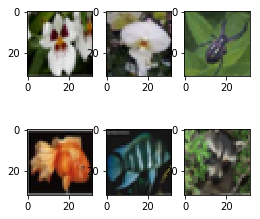

In [ ]:

for b in batch_generator(2,X):
  a = np.array(b[0], np.uint8)
  print(a.shape)
  image1 = a[0][0]
  image2 = a[1][0]
  image3 = a[2][0]
  image4 = a[0][1]
  image5 = a[1][1]
  image6 = a[2][1]
  fig=plt.figure(figsize=(4, 4))
  for i in range(1,7):
    fig.add_subplot(2, 3, i)
    if i==1:
      plt.imshow(image1)
    elif i==2:
      plt.imshow(image2)
    elif i==3:
      plt.imshow(image3)
    elif i==4:
      plt.imshow(image4)
    elif i==5:
      plt.imshow(image5)
    elif i==6:
      plt.imshow(image6)      
  plt.show()
  break

In [ ]:
import tensorflow as tf
def triplet_loss(ground_truth, network_output):
#     anchor, positive, negative = (x for x in tf.split(network_output, num_or_size_splits=3, axis=1))
#     pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
#     neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
#     margin = 0.1
#     basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
#     loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    total_lenght = 1536
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = network_output[:,0:int(total_lenght*1/3)]
    positive = network_output[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = network_output[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = K.mean(pos_dist-neg_dist+0.5)
    loss = K.maximum(basic_loss,0.0)
    return loss


In [ ]:
input_shape = (32, 32, 3)
anchor_input = Input(input_shape, name='anchor')
positive_input = Input(input_shape, name='positive')
negative_input = Input(input_shape, name='negative')

# build convnet to use in each siamese 'leg'
tripleNet = Sequential()

tripleNet.add(Conv2D(64, (5,5), input_shape=input_shape, kernel_regularizer=l2(2e-4), padding='SAME'))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.25))

tripleNet.add(Conv2D(128, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.25))

tripleNet.add(Conv2D(128, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.25))

tripleNet.add(Flatten())

tripleNet.add(Dense(512, activation="sigmoid", kernel_regularizer=l2(1e-3)))
tripleNet.summary()

encoded_anchor = tripleNet(anchor_input)
encoded_positive = tripleNet(positive_input)
encoded_negative = tripleNet(negative_input)

layer1 = Lambda(lambda t: K.l2_normalize(t, axis=1))(encoded_anchor)
layer2 = Lambda(lambda t: K.l2_normalize(t, axis=1))(encoded_positive)
layer3 = Lambda(lambda t: K.l2_normalize(t, axis=1))(encoded_negative)


merged_vector = concatenate([layer1, layer2, layer3], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
optimizer = optimizers.Adam(lr=0.0001)
model.compile(loss=triplet_loss, optimizer=optimizer)
model.summary()

# # show model
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
#                  rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
__________

In [ ]:
loops = 100
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(model, X)
    code_model = Model(inputs=model.get_layer("sequential_1").get_input_at(1), outputs=model.get_layer("sequential_1").get_output_at(1))
    test_acc = test_oneshot(code_model, X_test)
    if test_acc >= best_acc:
        print("********* New best one-shot accuracy, saving model ********")
        code_model.save(os.path.join(".", "code_model.h5"))
        best_acc = test_acc    

=== Training loop 1 ===
Epoch 1/1
625/625 [==============================] - 51s 81ms/step - loss: 0.0880
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 2 ===
Epoch 1/1
625/625 [==============================] - 50s 80ms/step - loss: 0.0802
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 4.0% accuracy for 20-way one-shot learning
=== Training loop 3 ===
Epoch 1/1
625/625 [==============================] - 48s 76ms/step - loss: 0.0778
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 4 ===
Epoch 1/1
625/625 [==============================] - 46s 74ms/step - loss: 0.0752
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an av

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

For each epoch we run the test_oneshot function to get the accuracy. We then save the weights every time we get a better accuracy. The best result we got is 9.2%.

In [ ]:
print(best_acc)

9.2


***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

Cifar-100 is a data set that consists of 100 possible classes to which one image can belong to. The well-known formula to obtain the accuracy of an item belongs to a class is $$ acc = \frac{1}{n}\% $$ where n is the total amount of classes. The evaluation of the first Siamese network required to be tested on 20 classes.

We therefore generated 20 test pairs, one of which contains pictures of the same class, the other one pictures of different class. Randomly guessing which of the 20 contains the correct one has a chance of  $$ acc = \frac{1}{20}\% = 5\% $$


**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

## Expected accuracy
Taking into account the task of classifier embeddings using the Cifar100, it is expected that the performance among the three distinct networks will be different. Initially, the Siameses network will be expected to have a better accuracy compared to a CNN, due to the fact that in this case, we are dealing with 100 classes with fewer examples each, therefore the CNN will not be able to learn something meaningful from the data set, since we don't have enough data for each class. Moreover, the Siamense network has been built explicitly for learning an embedding, not for a classification task as in the case of the CNN

On the other hand, the triplet network can be seen as an improvement of the Siameses network, because takes an anchor example and tries to bring positive examples closer while also pushing away negative examples. For that reason, the highest accuracy expected belongs to the Triplet Network.


 ## Obtained accuracy in 20-way one-shot learning

*   Siameses Network: 26.4%
*   Convolution Neural Network: 6.4%
*   Triplet Network: 9.2%
*   Random Guessing: 5%

Explain the reasons of the accuracy difference if there are any: training epochs, steps per epoch, optimizers

In order to have a fair comparison between these models, we used the same embedding dimension (128).
We tried several learning rates with different optimizers, and Adam seems to be the best one for our models. From the results, we can see that the Siamense works better than extracting codes from a CNN, and as explained before this was the predictable behavior. Although we expected better results with the Triplet network, we only got slightly better accuracy than random guessing. We tried several embeddings dimensions, a lot of different architectures and even different losses to improve this score, but nothing seemed really helpful. We presume then that (for this particular dataset), Siamense is the best model among the three.  It might be the case the for other datasets Triplet network is better than Siamense.
